# Section 5.3: Non-linear ODE system with two unknown parameters

This notebook reproduces the analyses in Section 5.3 of the manuscript, including Figure 5. 

## Setup 

We load the Julia environment specified in the `Project.toml` and `Manifest.toml` files: First, we activate this environment, then install all dependencies (if some packages are not yet installed), and print out which packages and versions are currently in our environment: 

In [1]:
using Pkg;

# all paths are relative to the `notebook` subfolder main folder, i.e., assuming `pwd()` outputs
# ".../DeepDynamicodelingWithJust2TimePoints/notebooks"

Pkg.activate("../.")
Pkg.instantiate()
Pkg.status()

  Activating environment at `~/Desktop/DeepDynamicModelingWithJust2TimePoints/Project.toml`


      Status `~/Desktop/DeepDynamicModelingWithJust2TimePoints/Project.toml`
  [6e4b80f9] BenchmarkTools v1.2.1
  [336ed68f] CSV v0.9.10
  [a93c6f00] DataFrames v1.2.2
  [aae7a2af] DiffEqFlux v1.44.0
  [31c24e10] Distributions v0.25.24
  [587475ba] Flux v0.12.8
  [033835bb] JLD2 v0.4.15
  [b964fa9f] LaTeXStrings v1.3.0
  [1dea7af3] OrdinaryDiffEq v5.65.5
  [91a5bcdd] Plots v1.23.5
  [112f6efa] VegaLite v2.6.0
  [9a3f8284] Random


Next, we load and precompile the necessary packages (in the versions specified by the `*.toml` files). 

In [2]:
using Distributions
using Random
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using Plots 
using LaTeXStrings
gr()

Plots.GRBackend()

Additionally, we import some user-defined functions, with different files for separate functionality.

In [3]:
include("../src/simulation.jl") # for simulating data
include("../src/model.jl") # for initializing and training the model
include("../src/plotting.jl") # for plotting data and learned trajectories

plot_batch_solution (generic function with 1 method)

## Data generation

First, we define the ground-truth developments as solutions of the underlying two-dimensional Lotka-Volterra ODE system with two distinct sets of parameters, corresponding to two groups of individuals with two distinct underlying development patterns. 

In [4]:
# initial condition
true_u0 = Float32[2, 2] 

# time interval
tspan = (0.0f0, 10.0f0)

# two sets of parameters for two distinct developments
true_odeparams_group1 = Float32[1.0, 1.0, 1.0, 0.5] 
true_odeparams_group2 = Float32[0.5, 1.0, 1.0, 2.0]

# define ODE problems, one for each group
lvprob1 = ODEProblem(lotka_volterra, true_u0, tspan, true_odeparams_group1)
lvprob2 = ODEProblem(lotka_volterra, true_u0, tspan, true_odeparams_group2)

# true trajectory of each group
dt=0.1
sol_group1 = solve(lvprob1, Tsit5(), saveat = dt);
sol_group2 = solve(lvprob2, Tsit5(), saveat = dt);

Now, we simulate data of `n`$=200$ individuals by adding noise to the true development patterns:

First, we randomly assign each individual into one of two groups, corresponding to the two distinct development patterns `sol_group1` and `sol_group2` created above. 

Next, for each simulated individual, we randomly draw a second measurement time point (or several subsequent random measurement time points) between `t_start`(here: $0$) and `t_end` (here: $10$) (here, `t_start`, `t_end`  $\in$ `tspan` is necessary). 

Then, for each individual, we simulate `p`$/2=5$ measurements of each dimension of the ODE solution, i.e., for a 2-dimensional ODE system as in this example, we have $2*$ `p`$=10$ variables. We do this by adding a variable-specific and an individual-specific measurement error to the true ODE solution of the individual's group at the individual-specific second measurement time point. These errors are drawn from to $\mathcal{N}(0,\sigma_{\mathrm{var}})$ and $\mathcal{N}(0,\sigma_{\mathrm{ind}})$, respectively.

The simulation design also allows for generating data at more than two time points, which can be set with the `maxntps` option specifying the maximum number of timepoints after the baseline visit. If `maxntps`$>1$, for each individual, a random number of time points between $1$ and `maxntps` is drawn, corresponding to the number of measurement time point available for that individual. 

In our current setting, we set $\sigma_{\mathrm{ind}} = \sigma_{\mathrm{var}} = 0.1$. 

In [5]:
# define numbers of individuals and variables 
n = 200
p = 10
q, q_info = 50, 20 

# set seed for reproducibility
Random.seed!(1234)

# generate time dependent and baseline variables
xs, tvals, group1, group2 = generate_xs(n, p, true_u0, sol_group1, sol_group2, t_start=0.0, maxntps=1, σ_var=0.1, σ_ind=0.1); # default vals: t_start=1.5, t_end=10, maxntps=10, dt=0.1, σ_var=0.1, σ_ind=0.5
x_baseline = generate_baseline(n, q, q_info, group1,  σ_info=0.5, σ_noise=0.5); # default vals: σ_info=1, σ_noise=1
data = simdata(xs, x_baseline, tvals, group1, group2);

We can now look at the data we generated (dots) and the true trajectories (solid lines): The plot shows the true ODE solutions as lines in the first row and the solutions and drawn measurements as dots in the second row, separately for each group (=column).

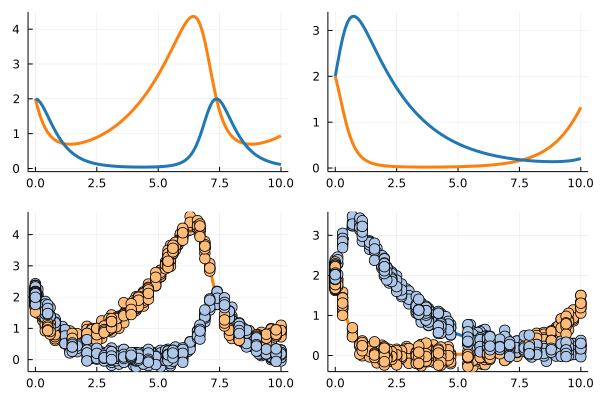

In [6]:
# look at data: 
data = simdata(xs, x_baseline, tvals, group1, group2);

plot(plot_truesolution(2, data, sol_group1, sol_group2, showdata=false), 
    plot_truesolution(1,  data, sol_group1, sol_group2, showdata=false), 
    plot_truesolution(2, data, sol_group1, sol_group2, showdata=true), 
    plot_truesolution(1,  data, sol_group1, sol_group2, showdata=true),
    layout = (2,2),
    legend = false
)

## Define and train model 

Next, we define the architecture of our model and initialize the model (with random weights). 

In [7]:
zdim = nODEparams = 2
m = init_vae(p, q, zdim, nODEparams, lvprob2, seed=84)

odevae(10, 50, 2, Chain(Dense(50, 50, tanh), Dense(50, 2, #26), Diagonal(2)), Dense(10, 10, #27), Dense(10, 2), Chain(Dense(10, 2, #28), Diagonal(2)), Dense(2, 10, tanh), Dense(10, 10), Dense(10, 10), ODEProblem{Vector{Float32}, Tuple{Float32, Float32}, true, Vector{Float32}, ODEFunction{true, typeof(lotka_volterra), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}(ODEFunction{true, typeof(lotka_volterra), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}(lotka_volterra, LinearAlgebra.UniformScaling{Bool}(true), nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing,

We specify the model loss, the optimizer and the learning rate for the stochastic gradient descent:

In [8]:
L = loss_wrapper(m)
ps = getparams(m)
opt = ADAM(0.0001)

ADAM(0.0001, (0.9, 0.999), IdDict{Any, Any}())

Finally, we define the training data for the model and define two callback functions: One to show the mean of the loss function across the dataset after each training epoch (to verify that it decreases), and one to plot the currently learned data encoding and trajectories from four exemplary individuals. 

In [9]:
trainingdata = zip(xs, x_baseline, tvals);
evalcb() = @show(mean(L.(xs, x_baseline, tvals)))
evalcb_zs() = eval_z_trajectories(xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt)

evalcb_zs (generic function with 1 method)

Now, it's time to start training!

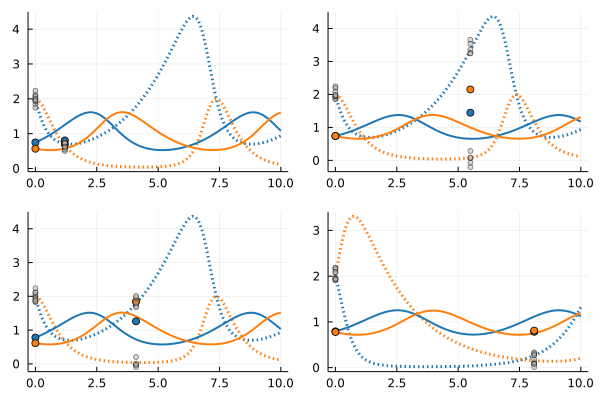

mean(L.(xs, x_baseline, tvals)) = 47.914583178035485
mean(L.(xs, x_baseline, tvals)) = 

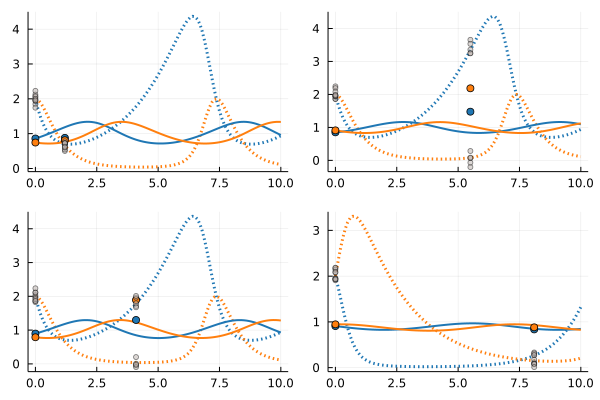

44.633770653216835


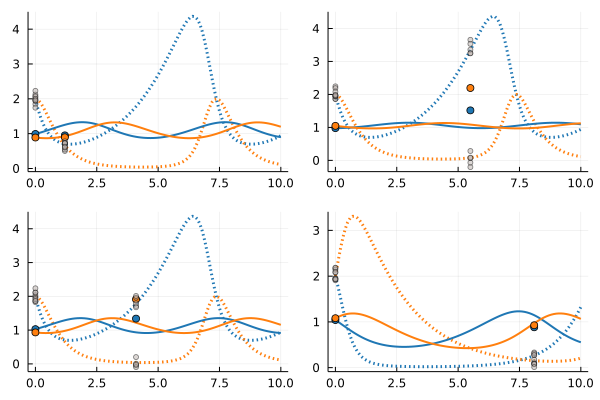

mean(L.(xs, x_baseline, tvals)) = 41.7639021904966
mean(L.(xs, x_baseline, tvals)) = 

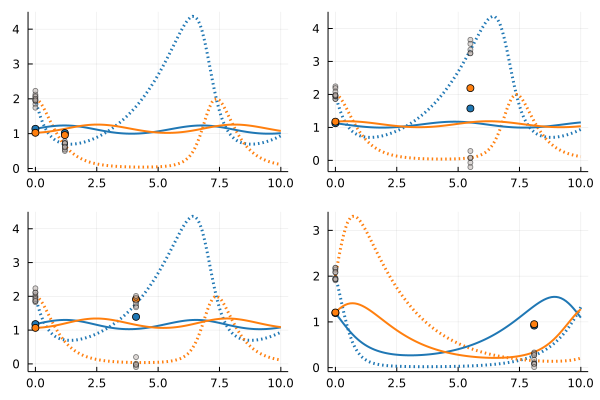

39.375792886036756


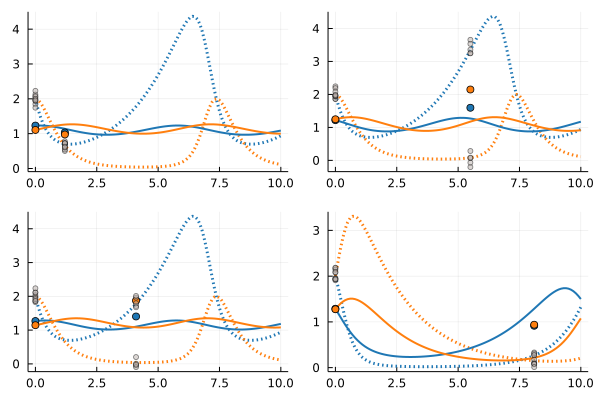

mean(L.(xs, x_baseline, tvals)) = 37.50274951571129
mean(L.(xs, x_baseline, tvals)) = 

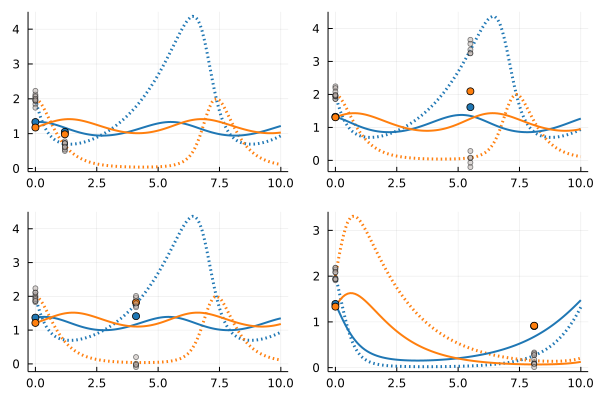

35.96452098228664


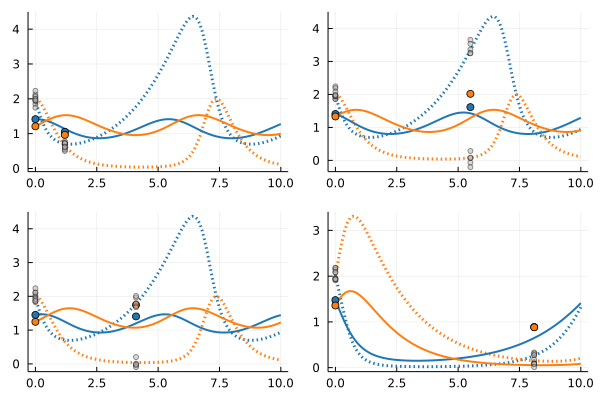

mean(L.(xs, x_baseline, tvals)) = 34.77218231314499
mean(L.(xs, x_baseline, tvals)) = 

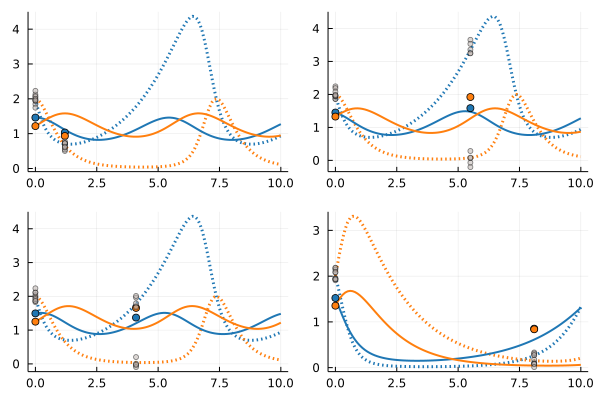

33.69010742985868


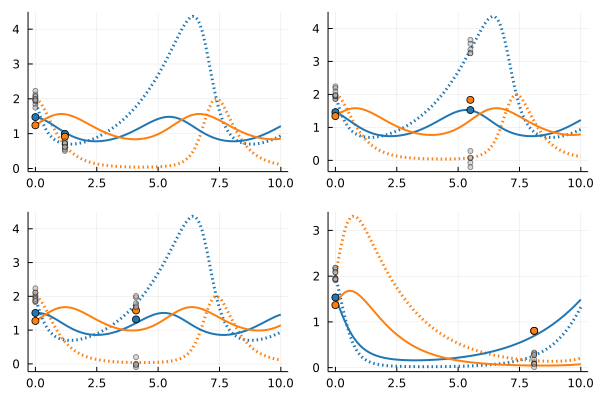

mean(L.(xs, x_baseline, tvals)) = 32.44039171835184
mean(L.(xs, x_baseline, tvals)) = 

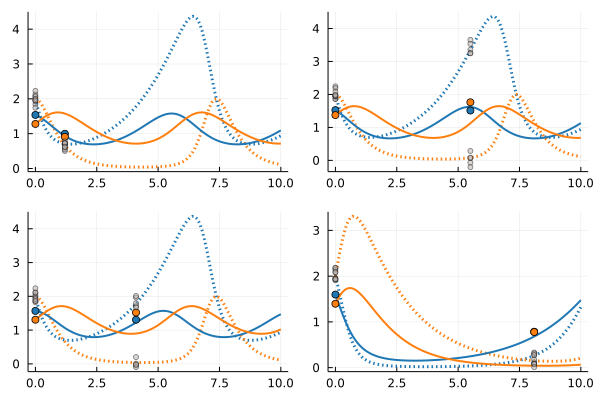

31.729276473838873


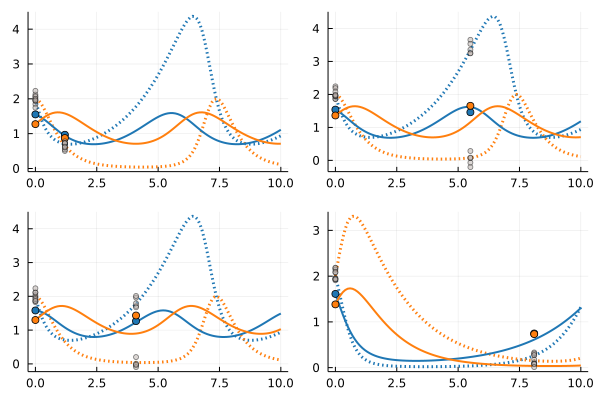

mean(L.(xs, x_baseline, tvals)) = 30.63599617286111
mean(L.(xs, x_baseline, tvals)) = 

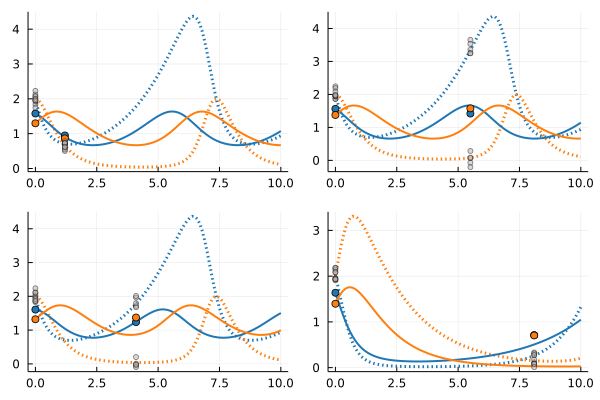

29.912446675404844


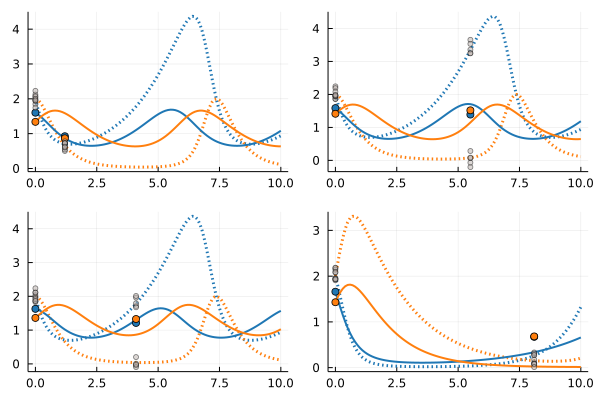

mean(L.(xs, x_baseline, tvals)) = 29.171071399816853
mean(L.(xs, x_baseline, tvals)) = 

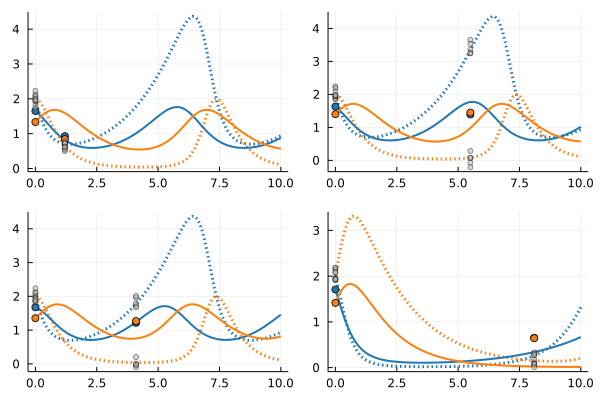

28.60788499769181


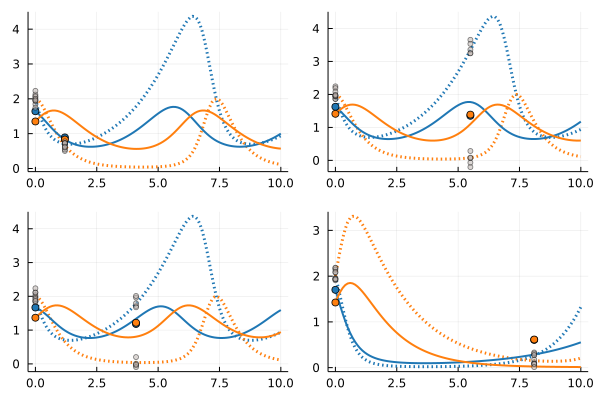

mean(L.(xs, x_baseline, tvals)) = 27.731785314013834
mean(L.(xs, x_baseline, tvals)) = 

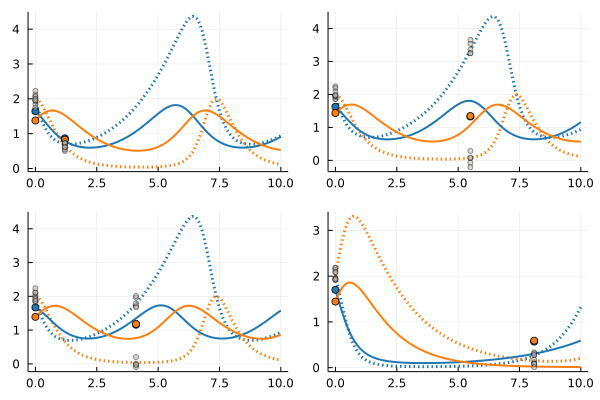

27.074170688828634


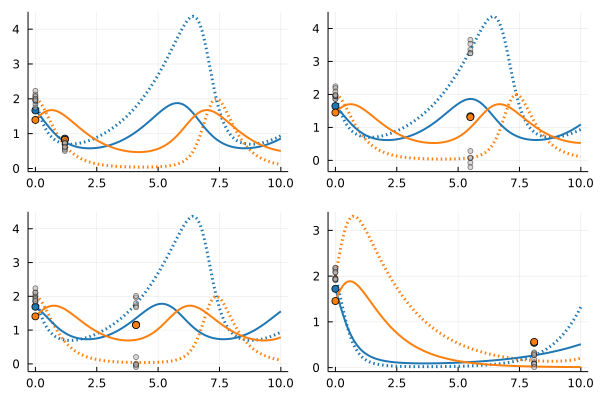

mean(L.(xs, x_baseline, tvals)) = 26.505295577333804
mean(L.(xs, x_baseline, tvals)) = 

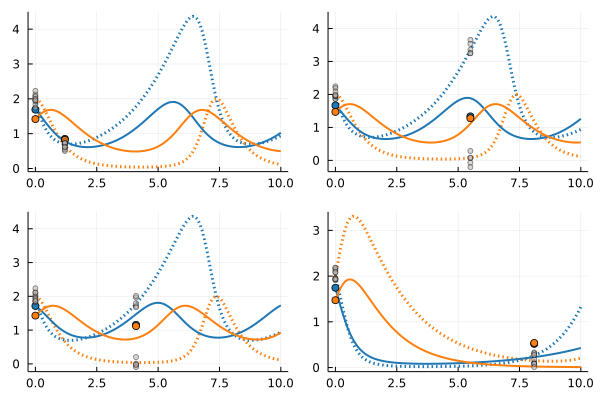

25.86462640721754


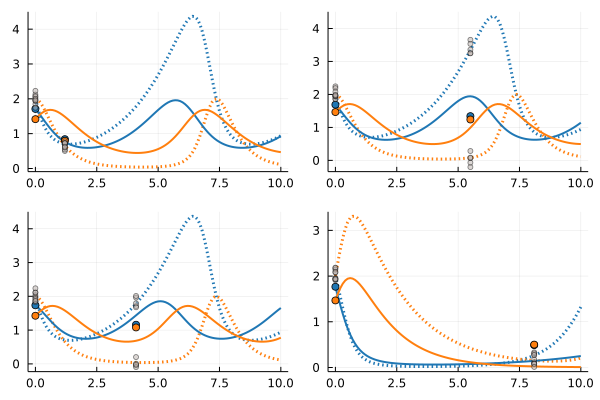

mean(L.(xs, x_baseline, tvals)) = 25.222364753333153
mean(L.(xs, x_baseline, tvals)) = 

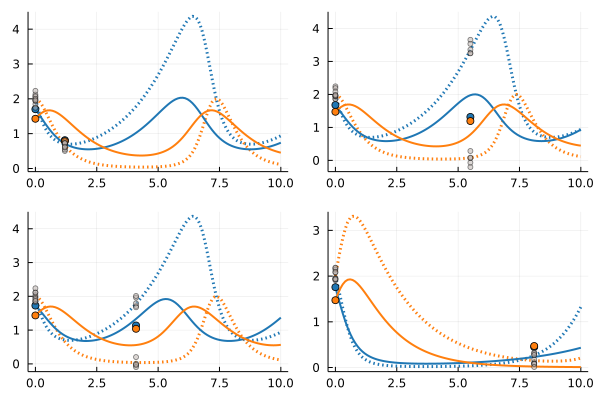

24.790766605529555


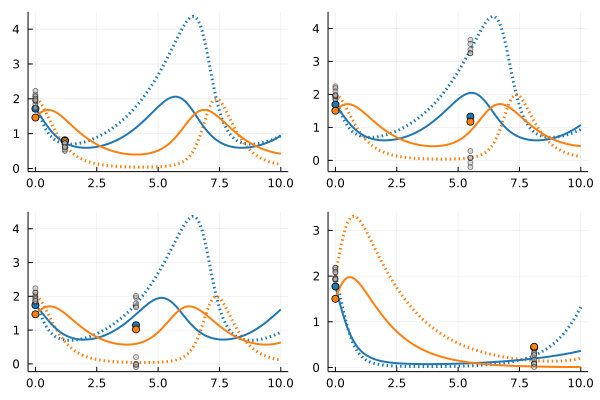

mean(L.(xs, x_baseline, tvals)) = 24.653086746610942
mean(L.(xs, x_baseline, tvals)) = 

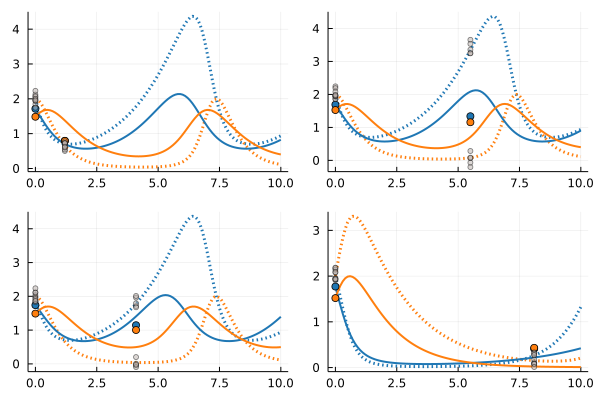

24.20959190047859


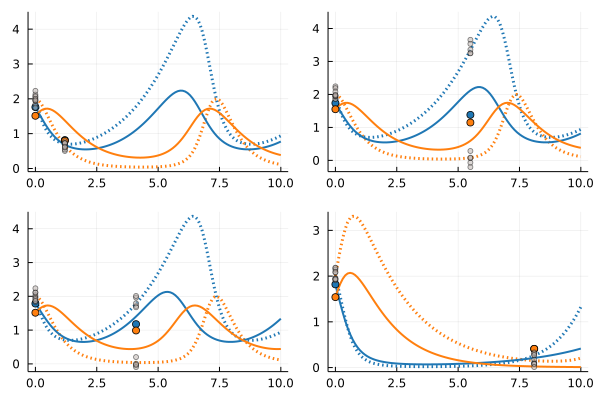

mean(L.(xs, x_baseline, tvals)) = 23.89731279485012
mean(L.(xs, x_baseline, tvals)) = 

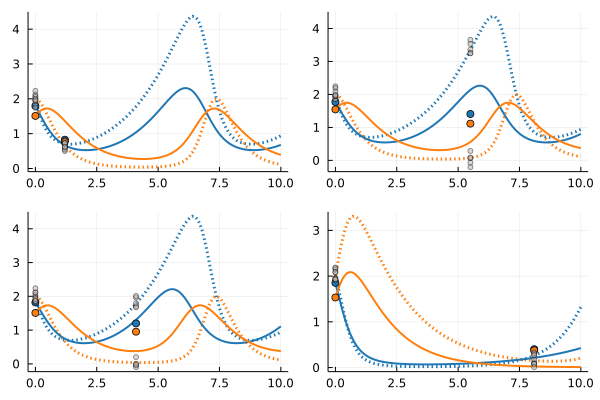

23.511746216827277


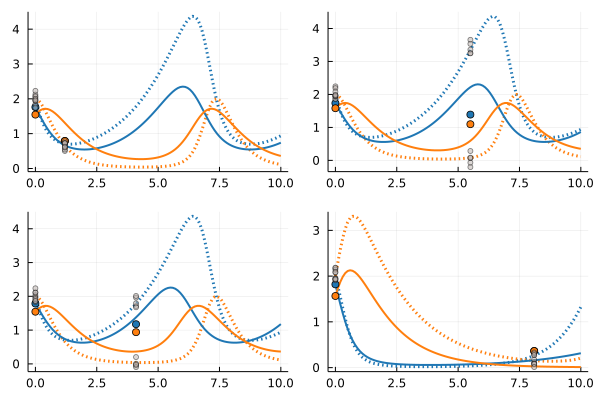

mean(L.(xs, x_baseline, tvals)) = 23.520695364322297
mean(L.(xs, x_baseline, tvals)) = 

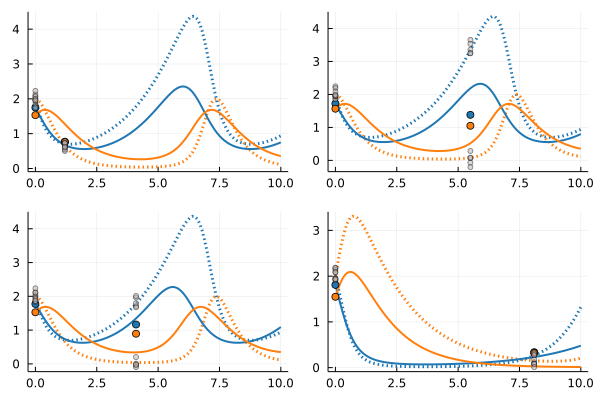

23.088268535716978


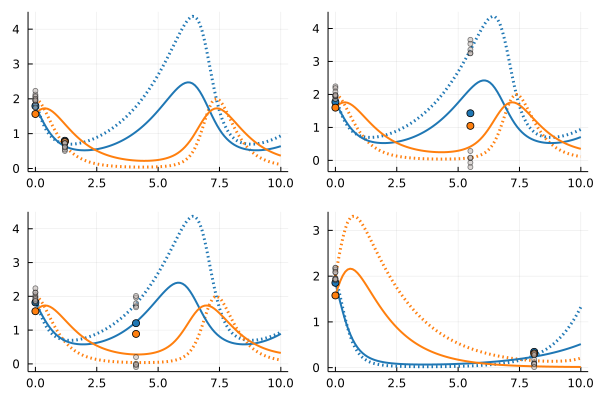

mean(L.(xs, x_baseline, tvals)) = 23.049243521135676
mean(L.(xs, x_baseline, tvals)) = 

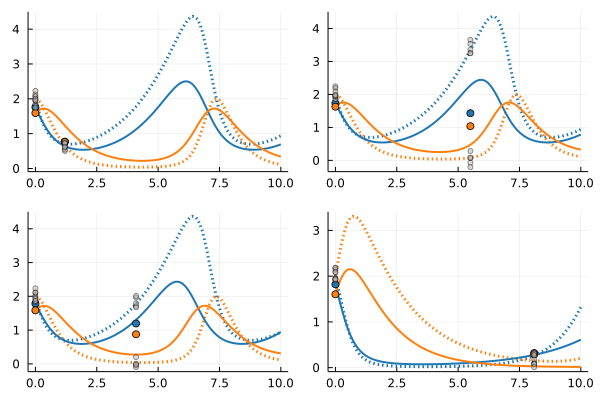

22.759038817053334


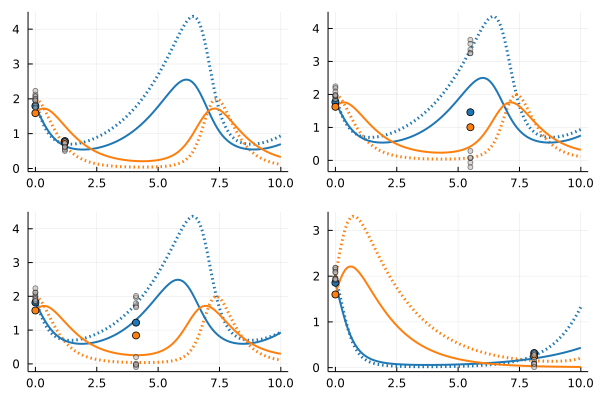

mean(L.(xs, x_baseline, tvals)) = 22.446802383692347
mean(L.(xs, x_baseline, tvals)) = 

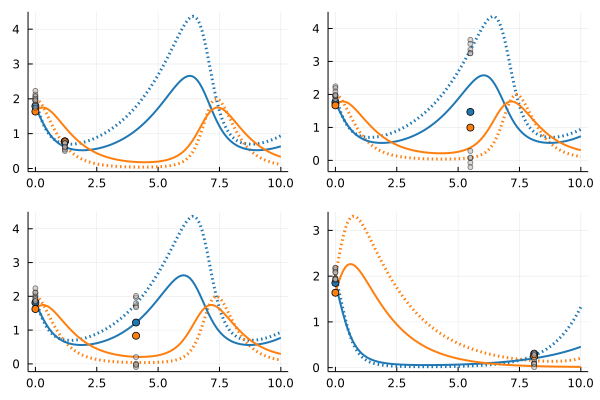

22.24809308620094


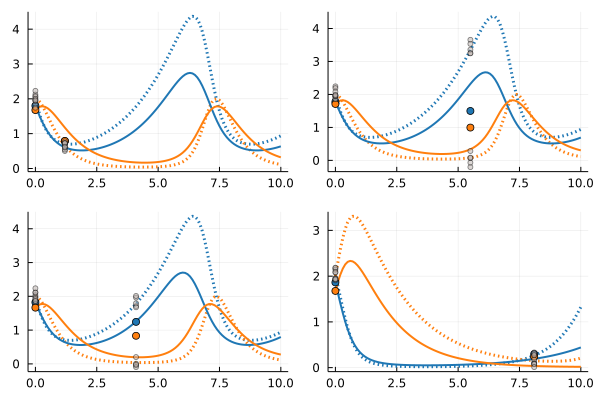

mean(L.(xs, x_baseline, tvals)) = 22.042886903980797
mean(L.(xs, x_baseline, tvals)) = 

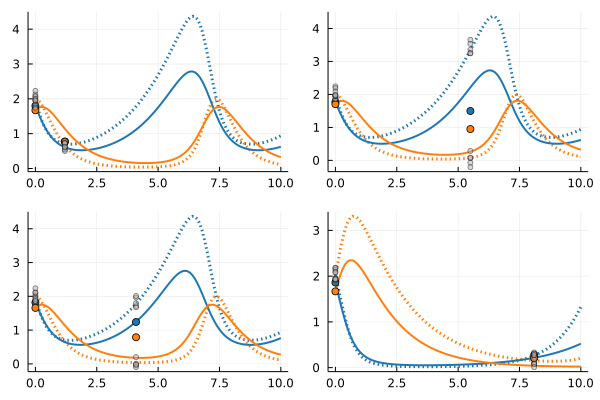

22.153900730775778


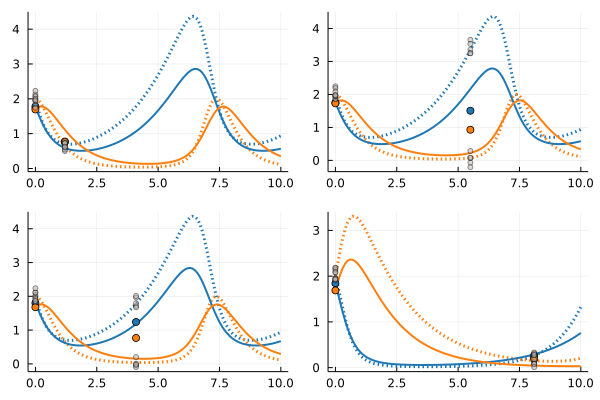

mean(L.(xs, x_baseline, tvals)) = 21.590519644304976
mean(L.(xs, x_baseline, tvals)) = 

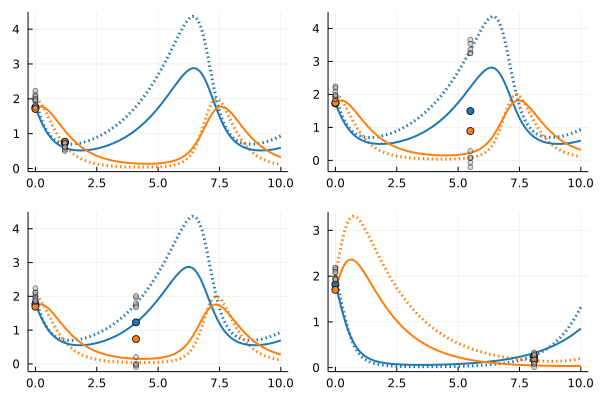

21.352929791531928


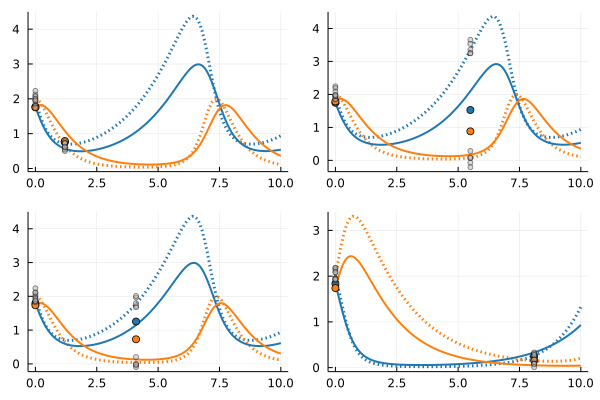

mean(L.(xs, x_baseline, tvals)) = 21.644821239673856
mean(L.(xs, x_baseline, tvals)) = 

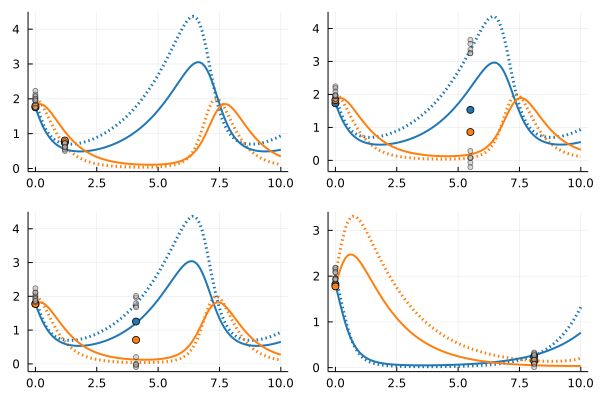

21.063774253865663


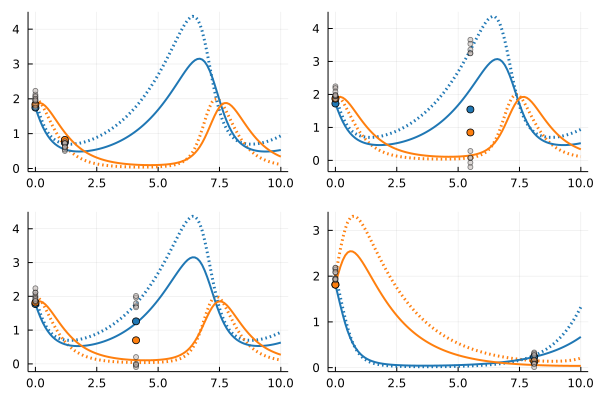

mean(L.(xs, x_baseline, tvals)) = 20.64012465010751
mean(L.(xs, x_baseline, tvals)) = 

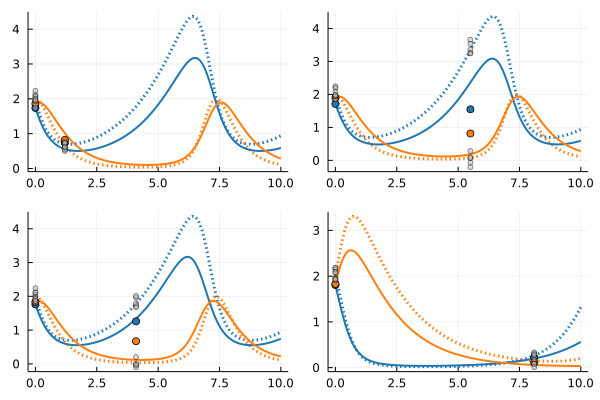

20.566042600718692


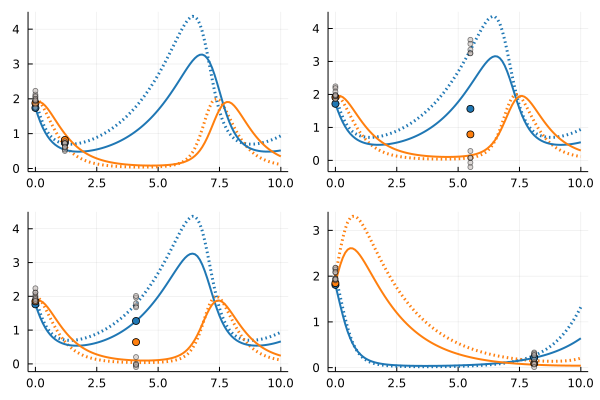

mean(L.(xs, x_baseline, tvals)) = 20.076373663291434
mean(L.(xs, x_baseline, tvals)) = 

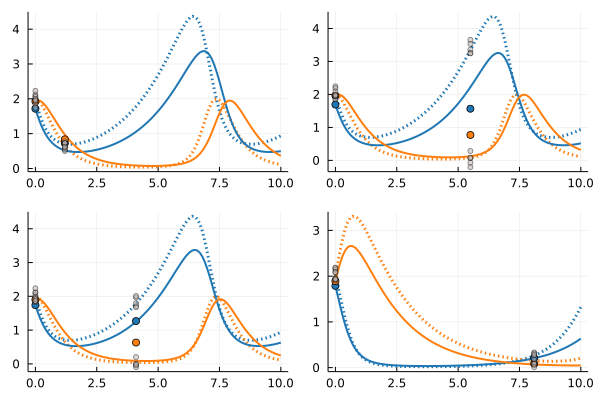

19.816609617225982


In [10]:
for epoch in 1:40
    Flux.train!(L, ps, trainingdata, opt)
    evalcb()
    evalcb_zs()
end

## Visualize results 

Finally, we can look at the results to evaluate what our model has learnt. 

We plot two individual solutions, one from each group, as well as the solutions across all individuals in each group. This reproduces the four panels of Figure 4. 

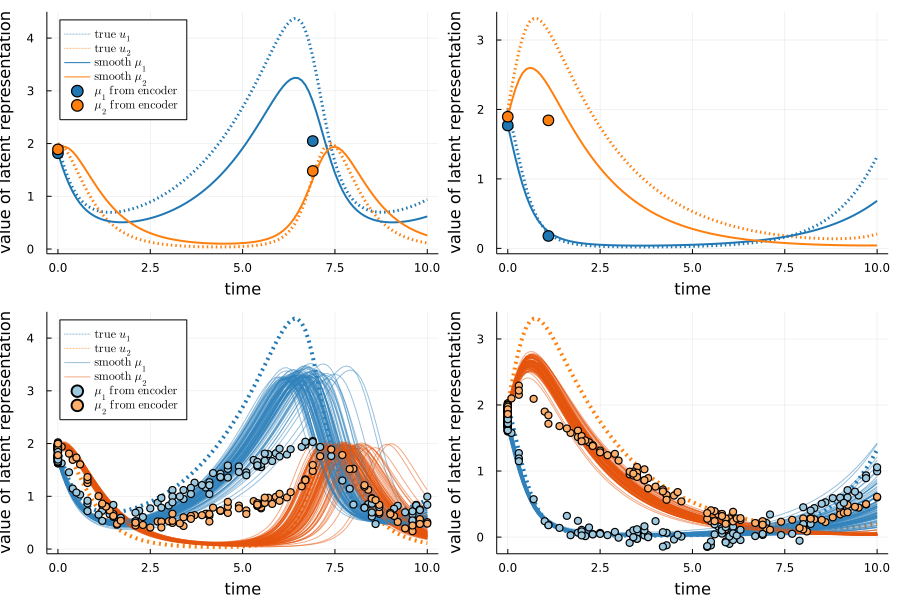

In [11]:
# individual plots 
p1 = plot_individual_solutions(46, xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt)
p2 = plot_individual_solutions(182, xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt, showlegend=false)

# solutions across the entire dataset
p3 = allindsplot(2, data, m, sol_group1, sol_group2)
p4 = allindsplot(1, data, m, sol_group1, sol_group2, showlegend=false)

display(plot(p1, p2, p3, p4, layout=(2,2), size=(900,600)))

Additionally, we can save the figures in the `figures` subfolder. 

In [12]:
# save results 
savefig(p1, "../figures/Figure5_topleft.pdf")
savefig(p2, "../figures/Figure5_topright.pdf")
savefig(p3, "../figures/Figure5_bottomleft.pdf")
savefig(p4, "../figures/Figure5_bottomright.pdf")